In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [3]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [4]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [5]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [6]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


In [7]:
#VGG19 
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [8]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 


In [9]:
#Load first n number of images (to train on a subset of all images)

n=5000
lr_list = os.listdir("data/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("data/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

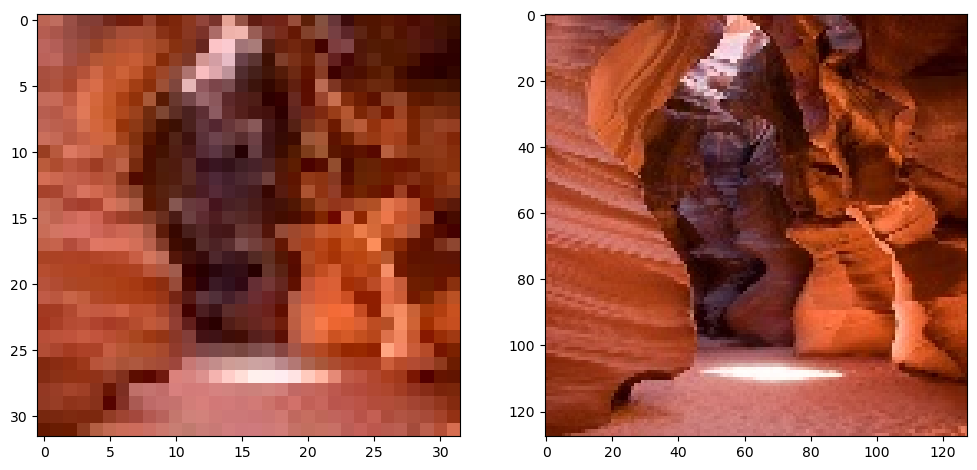

In [25]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [12]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [26]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 32, 32, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu_19 (PReLU)          (None, 32, 32, 64)           64        ['conv2d_45[0][0]']           
                                                                                                  
 conv2d_46 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_19[0][0]']          
                                                                                            

In [27]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_82 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_83 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_73 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                           

In [15]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [16]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3824928   ['model[0][0]']               
                                                          1                                 

In [17]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [40]:
'''epochs = 10
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")'''

1/1 [==============================] - 0s 66ms/step


 95%|█████████▍| 3171/3350 [1:14:06<05:19,  1.79s/it]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▍| 3172/3350 [1:14:07<05:06,  1.72s/it]

1/1 [==============================] - 0s 69ms/step


 95%|█████████▍| 3173/3350 [1:14:09<04:55,  1.67s/it]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▍| 3174/3350 [1:14:10<04:45,  1.62s/it]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▍| 3175/3350 [1:14:12<04:38,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▍| 3176/3350 [1:14:13<04:34,  1.58s/it]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▍| 3177/3350 [1:14:15<04:35,  1.59s/it]

1/1 [==============================] - 0s 80ms/step


 95%|█████████▍| 3178/3350 [1:14:17<04:50,  1.69s/it]

1/1 [==============================] - 0s 76ms/step


 95%|█████████▍| 3179/3350 [1:14:20<06:16,  2.20s/it]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▍| 3180/3350 [1:14:22<06:05,  2.15s/it]

1/1 [==============================] - 0s 68ms/step


 95%|█████████▍| 3181/3350 [1:14:24<05:46,  2.05s/it]

1/1 [==============================] - 0s 76ms/step


 95%|█████████▍| 3182/3350 [1:14:26<05:29,  1.96s/it]

1/1 [==============================] - 0s 71ms/step


 95%|█████████▌| 3183/3350 [1:14:28<05:20,  1.92s/it]

1/1 [==============================] - 0s 72ms/step


 95%|█████████▌| 3184/3350 [1:14:29<05:09,  1.86s/it]

1/1 [==============================] - 0s 72ms/step


 95%|█████████▌| 3185/3350 [1:14:31<05:02,  1.83s/it]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▌| 3186/3350 [1:14:33<04:53,  1.79s/it]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▌| 3187/3350 [1:14:35<04:43,  1.74s/it]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▌| 3188/3350 [1:14:36<04:38,  1.72s/it]

1/1 [==============================] - 0s 75ms/step


 95%|█████████▌| 3189/3350 [1:14:38<04:38,  1.73s/it]

1/1 [==============================] - 0s 71ms/step


 95%|█████████▌| 3190/3350 [1:14:40<04:35,  1.72s/it]

1/1 [==============================] - 0s 74ms/step


 95%|█████████▌| 3191/3350 [1:14:41<04:33,  1.72s/it]

1/1 [==============================] - 0s 68ms/step


 95%|█████████▌| 3192/3350 [1:14:43<04:26,  1.69s/it]

1/1 [==============================] - 0s 68ms/step


 95%|█████████▌| 3193/3350 [1:14:45<04:24,  1.69s/it]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▌| 3194/3350 [1:14:47<04:43,  1.82s/it]

1/1 [==============================] - 0s 71ms/step


 95%|█████████▌| 3195/3350 [1:14:50<06:01,  2.33s/it]

1/1 [==============================] - 0s 69ms/step


 95%|█████████▌| 3196/3350 [1:14:52<05:36,  2.19s/it]

1/1 [==============================] - 0s 80ms/step


 95%|█████████▌| 3197/3350 [1:14:54<05:19,  2.09s/it]

1/1 [==============================] - 0s 67ms/step


 95%|█████████▌| 3198/3350 [1:14:56<04:55,  1.95s/it]

1/1 [==============================] - 0s 68ms/step


 95%|█████████▌| 3199/3350 [1:14:57<04:39,  1.85s/it]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 3200/3350 [1:14:59<04:25,  1.77s/it]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 3201/3350 [1:15:00<04:10,  1.68s/it]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 3202/3350 [1:15:02<04:01,  1.63s/it]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 3203/3350 [1:15:03<03:50,  1.57s/it]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 3204/3350 [1:15:05<03:42,  1.53s/it]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 3205/3350 [1:15:06<03:37,  1.50s/it]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 3206/3350 [1:15:08<03:34,  1.49s/it]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 3207/3350 [1:15:09<03:32,  1.49s/it]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 3208/3350 [1:15:11<03:33,  1.50s/it]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 3209/3350 [1:15:12<03:29,  1.49s/it]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 3210/3350 [1:15:13<03:24,  1.46s/it]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 3211/3350 [1:15:15<03:21,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 3212/3350 [1:15:16<03:22,  1.47s/it]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 3213/3350 [1:15:18<03:21,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 3214/3350 [1:15:19<03:19,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 3215/3350 [1:15:21<03:21,  1.49s/it]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 3216/3350 [1:15:22<03:17,  1.47s/it]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 3217/3350 [1:15:24<03:13,  1.45s/it]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 3218/3350 [1:15:25<03:10,  1.44s/it]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 3219/3350 [1:15:27<03:09,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 3220/3350 [1:15:28<03:09,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 3221/3350 [1:15:30<03:08,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 3222/3350 [1:15:31<03:10,  1.49s/it]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 3223/3350 [1:15:33<03:05,  1.46s/it]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 3224/3350 [1:15:34<03:02,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▋| 3225/3350 [1:15:35<03:01,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▋| 3226/3350 [1:15:37<03:00,  1.45s/it]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▋| 3227/3350 [1:15:38<03:00,  1.47s/it]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▋| 3228/3350 [1:15:40<02:59,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▋| 3229/3350 [1:15:41<03:00,  1.49s/it]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▋| 3230/3350 [1:15:43<02:59,  1.49s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▋| 3231/3350 [1:15:44<02:55,  1.47s/it]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▋| 3232/3350 [1:15:46<02:51,  1.46s/it]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 3233/3350 [1:15:47<02:51,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 3234/3350 [1:15:49<02:50,  1.47s/it]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 3235/3350 [1:15:50<02:49,  1.48s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 3236/3350 [1:15:52<02:50,  1.50s/it]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 3237/3350 [1:15:53<02:46,  1.47s/it]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 3238/3350 [1:15:55<02:44,  1.47s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 3239/3350 [1:15:56<02:40,  1.45s/it]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 3240/3350 [1:15:57<02:40,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 3241/3350 [1:15:59<02:39,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 3242/3350 [1:16:00<02:38,  1.47s/it]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 3243/3350 [1:16:02<02:38,  1.48s/it]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 3244/3350 [1:16:03<02:34,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 3245/3350 [1:16:05<02:31,  1.45s/it]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 3246/3350 [1:16:06<02:29,  1.44s/it]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 3247/3350 [1:16:08<02:31,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 3248/3350 [1:16:09<02:30,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 3249/3350 [1:16:11<02:32,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 3250/3350 [1:16:12<02:31,  1.52s/it]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 3251/3350 [1:16:14<02:28,  1.50s/it]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 3252/3350 [1:16:15<02:25,  1.48s/it]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 3253/3350 [1:16:17<02:27,  1.52s/it]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 3254/3350 [1:16:18<02:24,  1.51s/it]

1/1 [==============================] - 0s 79ms/step


 97%|█████████▋| 3255/3350 [1:16:20<02:24,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 3256/3350 [1:16:21<02:24,  1.53s/it]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 3257/3350 [1:16:23<02:21,  1.52s/it]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 3258/3350 [1:16:24<02:17,  1.50s/it]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 3259/3350 [1:16:26<02:14,  1.48s/it]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 3260/3350 [1:16:27<02:15,  1.50s/it]

1/1 [==============================] - 0s 103ms/step


 97%|█████████▋| 3261/3350 [1:16:32<03:39,  2.47s/it]

1/1 [==============================] - 0s 82ms/step


 97%|█████████▋| 3262/3350 [1:16:34<03:24,  2.32s/it]

1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 3263/3350 [1:16:36<03:04,  2.12s/it]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 3264/3350 [1:16:37<02:45,  1.93s/it]

1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 3265/3350 [1:16:39<02:33,  1.80s/it]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 3266/3350 [1:16:40<02:25,  1.73s/it]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 3267/3350 [1:16:42<02:22,  1.72s/it]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 3268/3350 [1:16:44<02:19,  1.70s/it]

1/1 [==============================] - 0s 76ms/step


 98%|█████████▊| 3269/3350 [1:16:45<02:20,  1.73s/it]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 3270/3350 [1:16:47<02:14,  1.68s/it]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 3271/3350 [1:16:49<02:09,  1.64s/it]

1/1 [==============================] - 0s 78ms/step


 98%|█████████▊| 3272/3350 [1:16:50<02:10,  1.68s/it]

1/1 [==============================] - 0s 77ms/step


 98%|█████████▊| 3273/3350 [1:16:52<02:16,  1.77s/it]

1/1 [==============================] - 0s 77ms/step


 98%|█████████▊| 3274/3350 [1:16:54<02:15,  1.78s/it]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 3275/3350 [1:16:56<02:11,  1.75s/it]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 3276/3350 [1:16:57<02:07,  1.73s/it]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 3277/3350 [1:16:59<02:06,  1.73s/it]

1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 3278/3350 [1:17:01<02:08,  1.78s/it]

1/1 [==============================] - 0s 86ms/step


 98%|█████████▊| 3279/3350 [1:17:04<02:26,  2.06s/it]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 3280/3350 [1:17:06<02:19,  1.99s/it]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 3281/3350 [1:17:07<02:14,  1.95s/it]

1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 3282/3350 [1:17:09<02:09,  1.90s/it]

1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 3283/3350 [1:17:11<02:03,  1.85s/it]

1/1 [==============================] - 0s 80ms/step


 98%|█████████▊| 3284/3350 [1:17:14<02:22,  2.16s/it]

1/1 [==============================] - 0s 70ms/step


 98%|█████████▊| 3285/3350 [1:17:16<02:16,  2.10s/it]

1/1 [==============================] - 0s 80ms/step


 98%|█████████▊| 3286/3350 [1:17:18<02:08,  2.01s/it]

1/1 [==============================] - 0s 77ms/step


 98%|█████████▊| 3287/3350 [1:17:20<02:06,  2.01s/it]

1/1 [==============================] - 0s 83ms/step


 98%|█████████▊| 3288/3350 [1:17:22<02:03,  1.99s/it]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 3289/3350 [1:17:23<01:56,  1.91s/it]

1/1 [==============================] - 0s 78ms/step


 98%|█████████▊| 3290/3350 [1:17:25<01:51,  1.86s/it]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 3291/3350 [1:17:27<01:46,  1.81s/it]

1/1 [==============================] - 0s 74ms/step


 98%|█████████▊| 3292/3350 [1:17:28<01:43,  1.79s/it]

1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 3293/3350 [1:17:30<01:40,  1.77s/it]

1/1 [==============================] - 0s 76ms/step


 98%|█████████▊| 3294/3350 [1:17:32<01:38,  1.76s/it]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 3295/3350 [1:17:34<01:34,  1.71s/it]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 3296/3350 [1:17:35<01:30,  1.68s/it]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 3297/3350 [1:17:37<01:29,  1.68s/it]

1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 3298/3350 [1:17:39<01:28,  1.69s/it]

1/1 [==============================] - 0s 69ms/step


 98%|█████████▊| 3299/3350 [1:17:40<01:26,  1.70s/it]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▊| 3300/3350 [1:17:42<01:29,  1.79s/it]

1/1 [==============================] - 0s 64ms/step


 99%|█████████▊| 3301/3350 [1:17:44<01:26,  1.76s/it]

1/1 [==============================] - 0s 70ms/step


 99%|█████████▊| 3302/3350 [1:17:46<01:22,  1.72s/it]

1/1 [==============================] - 0s 67ms/step


 99%|█████████▊| 3303/3350 [1:17:47<01:20,  1.71s/it]

1/1 [==============================] - 0s 70ms/step


 99%|█████████▊| 3304/3350 [1:17:49<01:19,  1.73s/it]

1/1 [==============================] - 0s 72ms/step


 99%|█████████▊| 3305/3350 [1:17:51<01:18,  1.74s/it]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▊| 3306/3350 [1:17:53<01:16,  1.73s/it]

1/1 [==============================] - 0s 64ms/step


 99%|█████████▊| 3307/3350 [1:17:54<01:13,  1.71s/it]

1/1 [==============================] - 0s 67ms/step


 99%|█████████▊| 3308/3350 [1:17:56<01:10,  1.68s/it]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 3309/3350 [1:17:57<01:09,  1.69s/it]

1/1 [==============================] - 0s 71ms/step


 99%|█████████▉| 3310/3350 [1:17:59<01:08,  1.70s/it]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 3311/3350 [1:18:01<01:06,  1.72s/it]

1/1 [==============================] - 0s 79ms/step


 99%|█████████▉| 3312/3350 [1:18:03<01:13,  1.93s/it]

1/1 [==============================] - 0s 74ms/step


 99%|█████████▉| 3313/3350 [1:18:07<01:25,  2.32s/it]

1/1 [==============================] - 0s 72ms/step


 99%|█████████▉| 3314/3350 [1:18:09<01:19,  2.22s/it]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 3315/3350 [1:18:10<01:10,  2.02s/it]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 3316/3350 [1:18:12<01:03,  1.88s/it]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 3317/3350 [1:18:13<00:59,  1.80s/it]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 3318/3350 [1:18:15<00:54,  1.72s/it]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 3319/3350 [1:18:16<00:52,  1.68s/it]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 3320/3350 [1:18:18<00:48,  1.63s/it]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 3321/3350 [1:18:20<00:47,  1.65s/it]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 3322/3350 [1:18:21<00:46,  1.66s/it]

1/1 [==============================] - 0s 70ms/step


 99%|█████████▉| 3323/3350 [1:18:23<00:45,  1.68s/it]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 3324/3350 [1:18:25<00:44,  1.70s/it]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 3325/3350 [1:18:26<00:41,  1.66s/it]

1/1 [==============================] - 0s 64ms/step


 99%|█████████▉| 3326/3350 [1:18:28<00:40,  1.69s/it]

1/1 [==============================] - 0s 119ms/step


 99%|█████████▉| 3327/3350 [1:18:31<00:47,  2.08s/it]

1/1 [==============================] - 0s 73ms/step


 99%|█████████▉| 3328/3350 [1:18:33<00:45,  2.05s/it]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 3329/3350 [1:18:35<00:40,  1.94s/it]

1/1 [==============================] - 0s 72ms/step


 99%|█████████▉| 3330/3350 [1:18:37<00:38,  1.94s/it]

1/1 [==============================] - 0s 64ms/step


 99%|█████████▉| 3331/3350 [1:18:39<00:36,  1.90s/it]

1/1 [==============================] - 0s 79ms/step


 99%|█████████▉| 3332/3350 [1:18:41<00:34,  1.94s/it]

1/1 [==============================] - 0s 72ms/step


 99%|█████████▉| 3333/3350 [1:18:44<00:40,  2.38s/it]

1/1 [==============================] - 0s 61ms/step


100%|█████████▉| 3334/3350 [1:18:46<00:36,  2.25s/it]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 3335/3350 [1:18:48<00:30,  2.05s/it]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 3336/3350 [1:18:49<00:27,  1.93s/it]

1/1 [==============================] - 0s 59ms/step


100%|█████████▉| 3337/3350 [1:18:51<00:23,  1.80s/it]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 3338/3350 [1:18:52<00:20,  1.73s/it]

1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 3339/3350 [1:18:54<00:18,  1.64s/it]

1/1 [==============================] - 0s 74ms/step


100%|█████████▉| 3340/3350 [1:18:55<00:16,  1.62s/it]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 3341/3350 [1:18:57<00:14,  1.60s/it]

1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 3342/3350 [1:18:58<00:12,  1.57s/it]

1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 3343/3350 [1:19:00<00:10,  1.54s/it]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 3344/3350 [1:19:01<00:09,  1.52s/it]

1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 3345/3350 [1:19:03<00:07,  1.52s/it]

1/1 [==============================] - 0s 68ms/step


100%|█████████▉| 3346/3350 [1:19:04<00:06,  1.52s/it]

1/1 [==============================] - 0s 65ms/step


100%|█████████▉| 3347/3350 [1:19:06<00:04,  1.52s/it]

1/1 [==============================] - 0s 63ms/step


100%|█████████▉| 3348/3350 [1:19:07<00:03,  1.52s/it]

1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 3349/3350 [1:19:09<00:01,  1.52s/it]

1/1 [==============================] - 0s 61ms/step


100%|██████████| 3350/3350 [1:19:10<00:00,  1.42s/it]


epoch: 10 g_loss: 42.66649344899761 d_loss: [0.09185966 0.99686567]


/Users/sanjeebdey/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 808ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


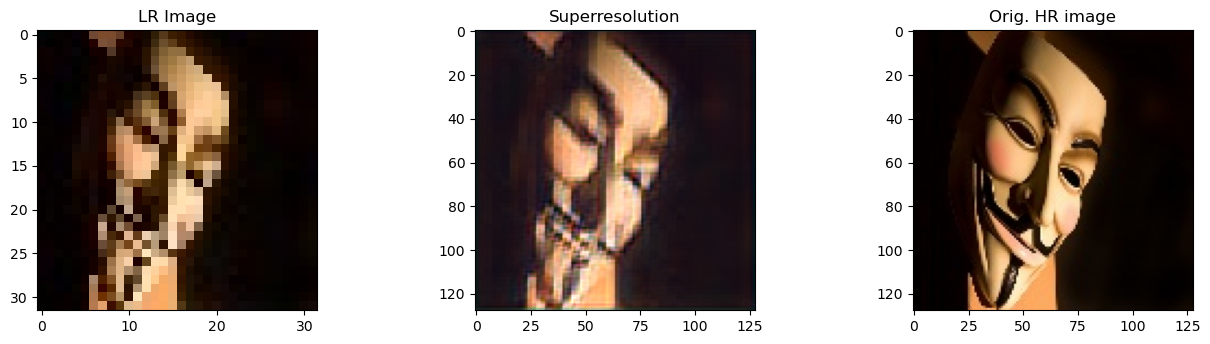

In [29]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()